# supp figure to get erro r per 100 residues for CAID2 analysis

In [1]:
import os
import metapredict as meta
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
import protfasta
import zipfile
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'
# set fonts
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

# set colors for plots here. Colors are for V1, v2, and v3. Chosen because Ryan can differentiate them.
v1color='#FF9D33'
v2color='#FF6433'
v3color='#CC2D46'
hybridcolor='black'
pLDDT_color='blue'


# NOTE! PLEASE DOWNLOAD THE .caid files for CAID2 from https://caid.idpcentral.org/assets/sections/challenge/static/predictions/2/predictions.zip
# this will download a file called 'predictions.zip' that you need to unzip in this folder to get this to work! 

In [2]:
if 'predictions' not in os.listdir():
    print("ERROR! You PLEASE DOWNLOAD THE .caid files for CAID2 from \nhttps://caid.idpcentral.org/assets/sections/challenge/static/predictions/2/predictions.zip \nthis will download a file called 'predictions.zip' that you need to unzip in this folder to get this to work!")

ERROR! You PLEASE DOWNLOAD THE .caid files for CAID2 from 
https://caid.idpcentral.org/assets/sections/challenge/static/predictions/2/predictions.zip 
this will download a file called 'predictions.zip' that you need to unzip in this folder to get this to work!


In [3]:
# Function to read in the CAID data from the fasta provided by CAID.
# read in the disorder_pdb.fasta
def read_caid_seq_disorder(caid_fasta_file):
    '''
    #NOTE
     this reads in the caid pdb .fasta file!
     
    function to read in the modified Caid2 
    fasta file that includes a header, the
    ID, the sequence, and then the scores as
    1 = disorder, 0 = not disordered, and 
    - = not assessed.
    
    Parameters
    ----------
    caid_file : str
        path to caid file as a str

    Returns
    --------
    seqs : dict
        dictionary of sequences and scores,
        keyed by ID
    '''
    caid_seqs_scores = {}
    PATH = os.path.dirname(os.path.realpath(caid_fasta_file))
    with open(f'{PATH}/{caid_fasta_file}', 'r') as fh:
        lines=fh.readlines()
    fh.close()

    # get seqs and lines
    seq_ind=0
    for n in range(0, len(lines),3):
        caid_seqs_scores[lines[n].strip()]={'sequence':lines[n+1].strip(), 'scores':lines[n+2].strip()}
    return caid_seqs_scores

# read in the caid2 data
caid2_data_read_in=read_caid_seq_disorder('caid2_disorder_pdb.fasta')

def read_caid_convert_get_predictor_vals(caid_file):
    '''
    Reads in a .caid file. This will not modify a cutoff value
    and will fail if the binary score does not exist. 
    
    Parameters
    ----------
    caid_file : str
        path to caid file as a string.
    
    Returns
    -------
    vals : list
        [predictor_vals, caid_vals]
    '''
    caid_vals=[]
    predictor_vals=[]
    total=0
    with open(caid_file, 'r') as fh:
        preds=fh.read().split('>')
        for p in preds:
            if p != '':
                pred_lines=p.split('\n')
                name=pred_lines[0]
                if '\t' in name:
                    name=name.split('\t')[0]
                # get current data for that protein.
                curdat=caid2_data_read_in[f'>{name}']['scores']
                score_ind=0
                for v in pred_lines:
                    splitvals=v.split('\t')
                    # now need to get the prediction value. This is tricky because
                    # the formatting is inconsistent across the files. yay.
                    if len(splitvals)>=3:
                        if len(splitvals)==4:
                            curpred=int(splitvals[-1])
                            actual = curdat[score_ind]
                            if actual!='-':
                                caid_vals.append(int(actual))
                                predictor_vals.append(curpred)
                            
                            score_ind+=1
                            total+=1
    fh.close()
    vals=[predictor_vals, caid_vals]
    return vals


def read_caid_convert_get_vals_allow_altered_cutoff(caid_file, cutoff=0.5):
    '''
    reads in a .caid file and then returns the per residue 
    error. Assumes 0.5 cutoff for disorder because I can't find any
    info on cutoffs anywhere on the caid website. 
    
    Parameters
    ----------
    caid_file : str
        path to caid file as a string.
        
    cutoff : float
        disorder cutoff value
    
    Returns
    -------
    mcc : float
        error per residue as a float
    '''
    caid_vals=[]
    predictor_vals=[]
    predictor_vals_raw=[]
    total=0
    with open(caid_file, 'r') as fh:
        preds=fh.read().split('>')
        for p in preds:
            if p != '':
                pred_lines=p.split('\n')
                name=pred_lines[0]
                if '\t' in name:
                    name=name.split('\t')[0]
                # get current data for that protein.
                curdat=caid2_data_read_in[f'>{name}']['scores']
                score_ind=0
                for v in pred_lines:
                    splitvals=v.split('\t')
                    # now need to get the prediction value. This is tricky because
                    # the formatting is inconsistent across the files. yay.
                    if len(splitvals)>=3:
                        if len(splitvals)==4:
                            if splitvals[-1]=='':
                                rawval=float(splitvals[-2])
                                if rawval>=cutoff:
                                    curpred=1
                                else:
                                    curpred=0
                            else:
                                curpred=int(splitvals[-1])
                                rawval=float(splitvals[-2])
                        elif len(splitvals)==3:
                            rawval=float(splitvals[-1])
                            if rawval>=cutoff:
                                curpred=1
                            else:
                                curpred=0
                        actual = curdat[score_ind]
                        if actual!='-':
                            caid_vals.append(int(actual))
                            predictor_vals.append(curpred)
                            predictor_vals_raw.append(rawval)
                        score_ind+=1
                        total+=1
    fh.close()
    vals=[predictor_vals, caid_vals]
    return vals




In [13]:
# read in metapredict v3 caid files
with open('metapredict_v3_combined.txt', 'r') as fh:
    dirstring=fh.read()
fh.close()
metapredict_v3_dict = eval(dirstring)
print('making folder for metapredict V3 caid files')
os.mkdir('metapredict_v3_caid_files')
print('making metapredict V3 caid files')
for caid_file in metapredict_v3_dict:
    with open(f'metapredict_v3_caid_files/{caid_file}', 'w') as fh:
        fh.write(metapredict_v3_dict[caid_file])
    fh.close()
print('Done!')

making folder for metapredict V3 caid files
making metapredict V3 caid files
Done!


In [14]:
# read caid2 data into a dict
# get list of caid predictors that should exist *and have binarized scores*. 
caid2_predictors_with_binarized_scores=['VSL2.caid','AUCpred-no-profile.caid','SPOT-Disorder.caid','SPOT-Disorder-Single.caid','flDPnn.caid','pyHCA.caid','DeepIDP-2L.caid','AIUPred.caid','ESpritz-X.caid','ENSHROUD-all.caid','PredIDR-short.caid','IDP-Fusion.caid','IsUnstruct.caid','DisoPred.caid','SETH-1.caid','MobiDB-lite.caid','DISOPRED3-diso.caid','SPOT-Disorder2.caid','IUPred3.caid','ESpritz-N.caid','PreDisorder.caid','APOD.caid','flDPlr2.caid','SETH-0.caid','AUCpred-profile.caid','Dispredict3.caid','flDPtr.caid','PredIDR-long.caid','s2D.caid','ESpritz-D.caid','flDPnn2.caid','Dispredict2.caid', 'metapredict_v3.caid']

# dict that lack binarized scores but *do have publicly available disorder cutoff thresholds that I could find*. values == threshold. 
caid2_predictors_without_binarized_scores={'AlphaFold-rsa.caid': 0.581, 'AlphaFold-disorder.caid':0.312, 'RONN.caid':0.5, 'FoldUnfold.caid':0.5}

# dict to hold caid2 data
calculated_dat={}
for v in caid2_predictors_with_binarized_scores:
    dat = read_caid_convert_get_predictor_vals(f'predictors/{v}')
    predictor_vals=dat[0]
    caid_vals=dat[1]
    if len(predictor_vals)!=len(caid_vals):
        raise Exception('predictor val length does not equal caid vals!')
    total=0
    correct=0
    for n, pred_val in enumerate(predictor_vals):
        caid_val=caid_vals[n]
        if pred_val==caid_val:
            correct+=1
        total+=1
    calculated_dat[v.split('.caid')[0]]={'correct':correct, 'total':total}

# now add in additional data that has the manually currated cutoff values
for v in caid2_predictors_without_binarized_scores:
    cutoff=caid2_predictors_without_binarized_scores[v]
    dat = read_caid_convert_get_vals_allow_altered_cutoff(f'predictors/{v}', cutoff=cutoff)
    predictor_vals=dat[0]
    caid_vals=dat[1]
    if len(predictor_vals)!=len(caid_vals):
        raise Exception('predictor val length does not equal caid vals!')
    total=0
    correct=0
    for n, pred_val in enumerate(predictor_vals):
        caid_val=caid_vals[n]
        if pred_val==caid_val:
            correct+=1
        total+=1
    calculated_dat[v.split('.caid')[0]]={'correct':correct, 'total':total}




In [74]:
final_scores={}
for i in calculated_dat:
    correct=calculated_dat[i]['correct']
    total=calculated_dat[i]['total']
    percent_correct=correct/total
    out_of_100=percent_correct*100
    final_scores[i]=out_of_100
# sort by vals
sorted_dict = dict(sorted(final_scores.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)

{'AlphaFold-rsa': 91.13403055568942, 'SPOT-Disorder2': 90.96468167790604, 'metapredict_v3': 90.81580415199004, 'SETH-0': 90.61255988447168, 'IDP-Fusion': 90.32834349781311, 'SPOT-Disorder': 90.32526723564874, 'AlphaFold-disorder': 89.8481854547207, 'DeepIDP-2L': 88.64277145716972, 'AUCpred-profile': 88.5965604914486, 'SETH-1': 88.30122939859562, 'DisoPred': 88.2119587243196, 'PredIDR-long': 87.43018253780266, 'ENSHROUD-all': 87.33620116598027, 'SPOT-Disorder-Single': 86.90984664990793, 'pyHCA': 86.79294299227519, 'IUPred3': 86.44070386698962, 'PredIDR-short': 86.37499331433331, 'DISOPRED3-diso': 85.59487152058803, 'AUCpred-no-profile': 85.11732389953927, 'IsUnstruct': 84.3196283533394, 'AIUPred': 84.2187702957739, 'ESpritz-N': 83.3561282731114, 'flDPlr2': 83.00416756044496, 'MobiDB-lite': 82.9175485379402, 'flDPnn': 82.45528244076499, 'PreDisorder': 81.51886168100596, 'RONN': 80.39686117499637, 'ESpritz-D': 80.15770532637515, 'VSL2': 80.15464902160043, 'Dispredict3': 80.11186075475446,

In [137]:
# make the figs!

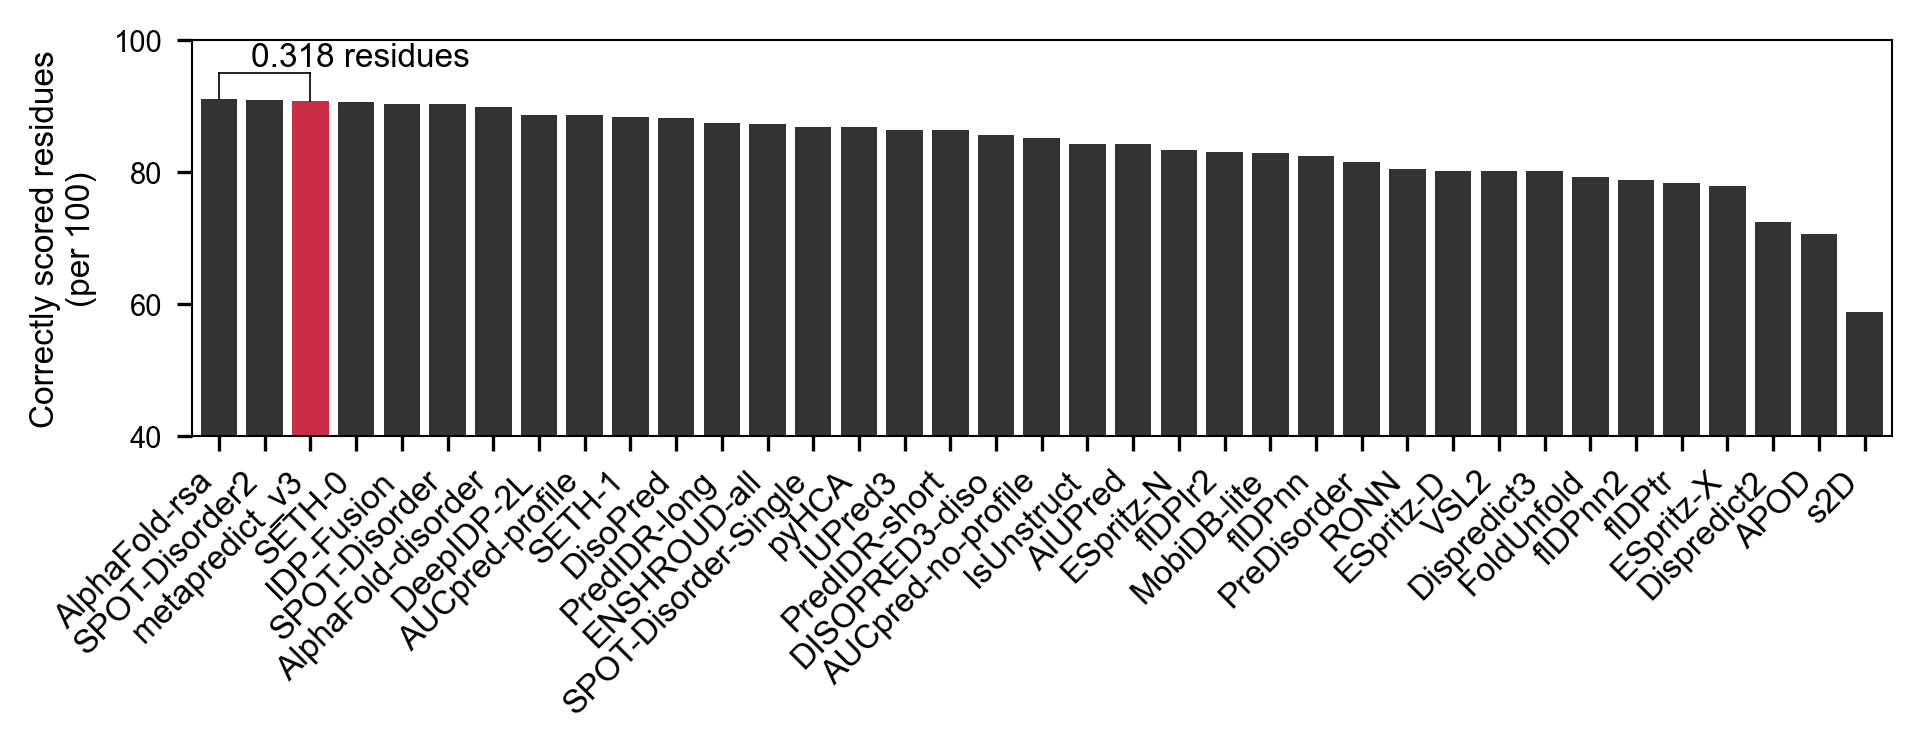

In [160]:
figure(num=None, figsize=(6.5, 2.6), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()

# this builds ordered data wuth a gap for metapredict (done manually)
s1=list(sorted_dict.values())
n1=list(sorted_dict.keys())

plt.bar(np.arange(1,len(s1)+1), s1, color='k', alpha=0.8)
plt.bar(n1.index('metapredict_v3')+1, s1[n1.index('metapredict_v3')], color=v3color)
plt.ylim([40,100])
plt.yticks(fontsize=7)
plt.ylabel('Correctly scored residues\n(per 100)',fontsize=8)
plt.xticks(np.arange(1,len(n1)+1), n1, fontsize=8, rotation=45, 
           verticalalignment='top', horizontalalignment='right')


# plot lines for visually comparing
plt.plot([1,1],[s1[0],95],'-k', linewidth=0.4)
plt.plot([1,n1.index('metapredict_v3')+1],[95,95],'-k', linewidth=0.4)
plt.plot([n1.index('metapredict_v3')+1, n1.index('metapredict_v3')+1],[95, s1[n1.index('metapredict_v3')]],'-k', linewidth=0.4)
error_to_meta = round(abs(s1[n1.index('metapredict_v3')]-s1[0]),3)
plt.text(1.7,96,f'{error_to_meta} residues', fontsize=8)
plt.xlim([0.4, len(n1)+0.6])
plt.tight_layout()
plt.savefig('metapredict_v3_vs_all_accuracy_per_100.pdf')


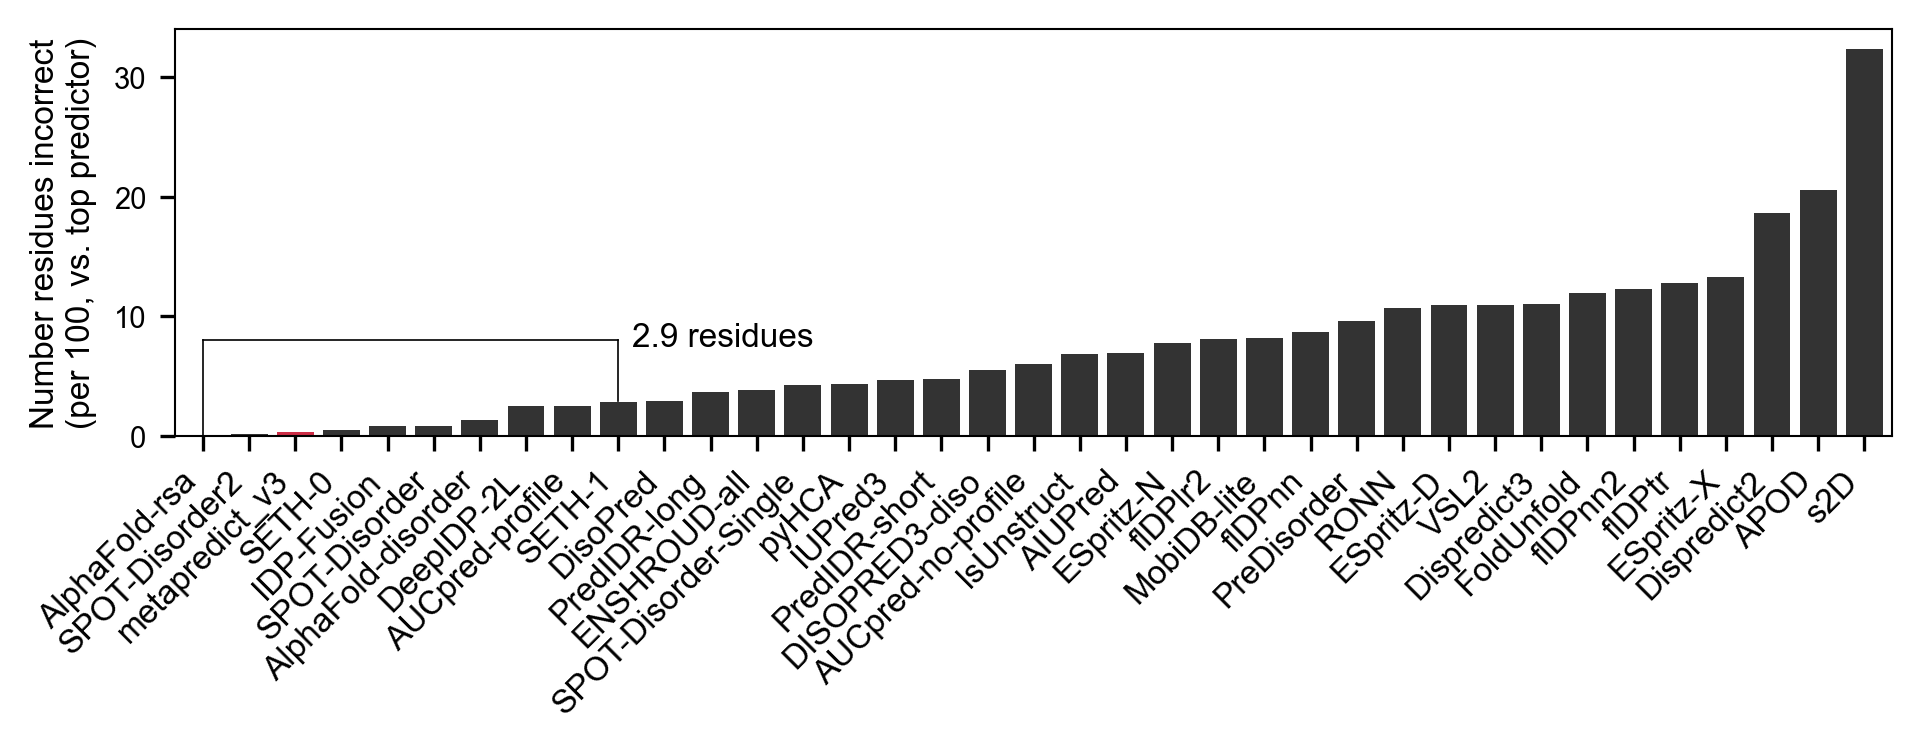

In [161]:
# make another plot
figure(num=None, figsize=(6.5, 2.6), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()

# this builds ordered data wuth a gap for metapredict (done manually)
s1=list(sorted_dict.values())
n1=list(sorted_dict.keys())
# change s1 list to subtract s1[0]
s1=[abs(a-s1[0]) for a in s1]

plt.bar(np.arange(1,len(s1)+1), s1, color='k', alpha=0.8)
plt.bar(n1.index('metapredict_v3')+1, s1[n1.index('metapredict_v3')], color=v3color)
#plt.ylim([40,100])
plt.yticks(fontsize=7)
plt.ylabel('Number residues incorrect\n(per 100, vs. top predictor)',fontsize=8)
plt.xticks(np.arange(1,len(n1)+1), n1, fontsize=8, rotation=45, 
           verticalalignment='top', horizontalalignment='right')


# plot lines for visually comparing
plt.plot([1,1],[s1[0],8],'-k', linewidth=0.4)
plt.plot([1, 10], [8,8] ,color='black', linewidth=0.4)
plt.plot([10, 10], [8, s1[10]],color='black', linewidth=0.4)
error_to_10th = round(abs(s1[10]-s1[0]),1)
plt.text(10.3,7.5,f'{error_to_10th} residues', fontsize=8)
plt.xlim([0.4, len(n1)+0.6])
plt.tight_layout()
plt.savefig('difference_in_accuracy_per_100_res.pdf')
